In [22]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [23]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [24]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6


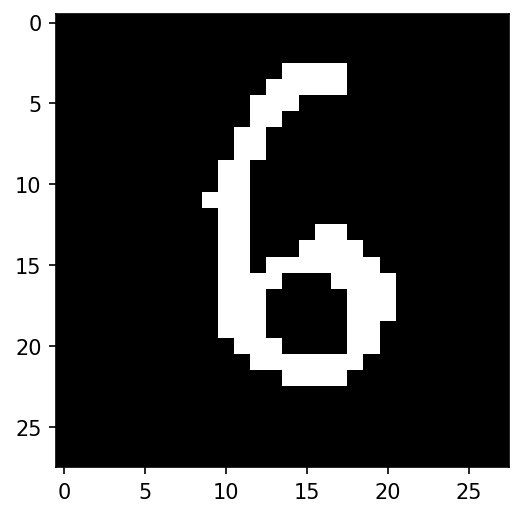

In [25]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img, cmap="gray")

In [26]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [27]:
# Training setup
model = AutoEncoder(in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# Training the autoencoder

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader)}")


ValueError: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 1, 25, 25])) is deprecated. Please ensure they have the same size.